In [ ]:
# Imports
import numpy as np
import time, random, math, itertools
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [ ]:
# Load Dataset and Split
(x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()

print("Original shapes:")
print("Train full:", x_train_full.shape, y_train_full.shape)
print("Test:", x_test.shape, y_test.shape)


x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y_train_full
)

print("\nAfter split:")
print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Original shapes:
Train full: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)

After split:
Train: (48000, 28, 28) (48000,)
Val:   (12000, 28, 28) (12000,)
Test:  (10000, 28, 28) (10000,)


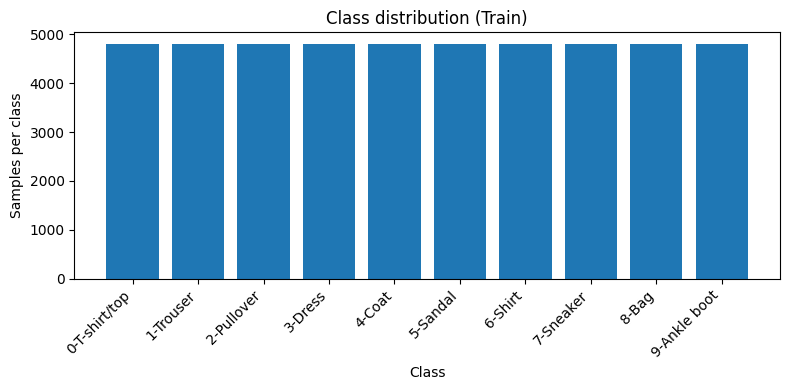

In [ ]:
# EDA — Class Distribution
counts = Counter(y_train.tolist())
xs, ys = list(range(10)), [counts[i] for i in range(10)]

plt.figure(figsize=(8,4))
plt.bar(xs, ys)
plt.xticks(xs, [f"{i}-{CLASS_NAMES[i]}" for i in xs], rotation=45, ha='right')
plt.title("Class distribution (Train)")
plt.xlabel("Class")
plt.ylabel("Samples per class")
plt.tight_layout()
plt.show()


In [ ]:
# EDA — Pixel Statistics
def global_mean_std(arrays):
    flat = np.concatenate([a.reshape(-1) for a in arrays])
    return float(np.mean(flat)), float(np.std(flat))

global_mean_before, global_std_before = global_mean_std([x_train])
print(f"Global pixel mean={global_mean_before:.3f}, std={global_std_before:.3f}")


for c in range(10):
    cls_imgs = x_train[y_train == c]
    print(f"Class {c} ({CLASS_NAMES[c]}): mean pixel={cls_imgs.mean():.3f}")


Global pixel mean=72.994, std=90.059
Class 0 (T-shirt/top): mean pixel=82.850
Class 1 (Trouser): mean pixel=56.987
Class 2 (Pullover): mean pixel=96.492
Class 3 (Dress): mean pixel=66.122
Class 4 (Coat): mean pixel=98.100
Class 5 (Sandal): mean pixel=34.800
Class 6 (Shirt): mean pixel=84.826
Class 7 (Sneaker): mean pixel=42.838
Class 8 (Bag): mean pixel=90.169
Class 9 (Ankle boot): mean pixel=76.761


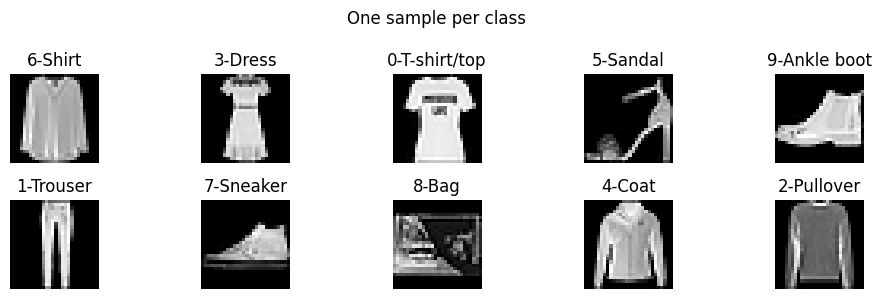

In [ ]:
#EDA — Sample Visualization
plt.figure(figsize=(10,3))
shown = set()
for i in range(len(x_train)):
    c = y_train[i]
    if c not in shown:
        plt.subplot(2,5,len(shown)+1)
        plt.imshow(x_train[i], cmap='gray')
        plt.title(f"{c}-{CLASS_NAMES[c]}")
        plt.axis('off')
        shown.add(c)
        if len(shown) == 10: break
plt.suptitle("One sample per class")
plt.tight_layout()
plt.show()


In [ ]:
# Preprocessing — Flatten + StandardScaler
x_train_flat = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_val_flat   = x_val.reshape((x_val.shape[0], -1)).astype(np.float32)
x_test_flat  = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

mean_before, std_before = x_train_flat.mean(), x_train_flat.std()

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_val_scaled   = scaler.transform(x_val_flat)
x_test_scaled  = scaler.transform(x_test_flat)

mean_after, std_after = x_train_scaled.mean(), x_train_scaled.std()

print(f"Before scaling: mean={mean_before:.4f}, std={std_before:.4f}")
print(f"After scaling:  mean={mean_after:.4f}, std={std_after:.4f}")


Before scaling: mean=72.9944, std=90.0594
After scaling:  mean=0.0000, std=1.0000


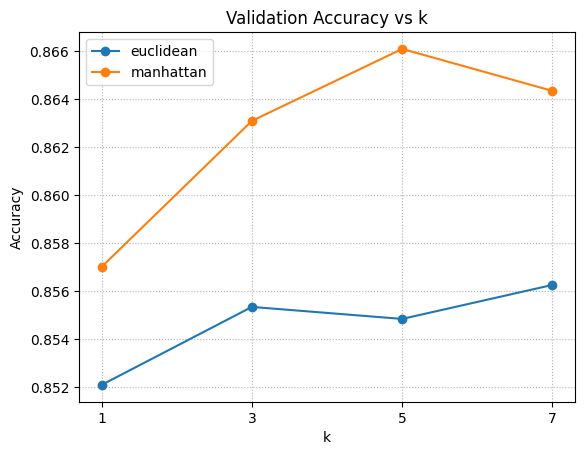

k | metric | val_acc | fit_t | pred_t
1  euclidean 0.8521 0.023s 2.503s
3  euclidean 0.8553 0.009s 2.349s
5  euclidean 0.8548 0.008s 2.288s
7  euclidean 0.8562 0.008s 2.125s
1  manhattan 0.8570 0.008s 37.431s
3  manhattan 0.8631 0.008s 35.380s
5  manhattan 0.8661 0.009s 35.404s
7  manhattan 0.8643 0.009s 35.999s


In [ ]:
# Hyperparameter Tuning (k, metric)
k_values = [1,3,5,7]
metrics = ["euclidean", "manhattan"]
val_results = []

for metric in metrics:
    accs = []
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
        t0f = time.time(); clf.fit(x_train_scaled, y_train); fit_t = time.time()-t0f
        t0p = time.time(); y_val_pred = clf.predict(x_val_scaled); pred_t = time.time()-t0p
        acc = accuracy_score(y_val, y_val_pred)
        val_results.append((k, metric, acc, fit_t, pred_t))
        accs.append(acc)
    plt.plot(k_values, accs, marker='o', label=metric)

plt.title("Validation Accuracy vs k")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.xticks(k_values); plt.legend(); plt.grid(True, linestyle=':')
plt.show()

print("k | metric | val_acc | fit_t | pred_t")
for k,metric,acc,ft,pt in val_results:
    print(f"{k:<2d} {metric:<9s} {acc:.4f} {ft:.3f}s {pt:.3f}s")


In [ ]:
# Select best hyperparameters
best = max(val_results, key=lambda x: (x[2], -x[0], x[1]=="euclidean"))
best_k, best_metric, best_acc = best[:3]
print(f"\nBest on validation → k={best_k}, metric={best_metric}, acc={best_acc:.4f}")



Best on validation → k=5, metric=manhattan, acc=0.8661


Best params: k=5, metric=manhattan
Test Accuracy=0.8613, Macro P=0.8625, R=0.8613, F1=0.8609
Training time=0.031s | Prediction time=46.206s


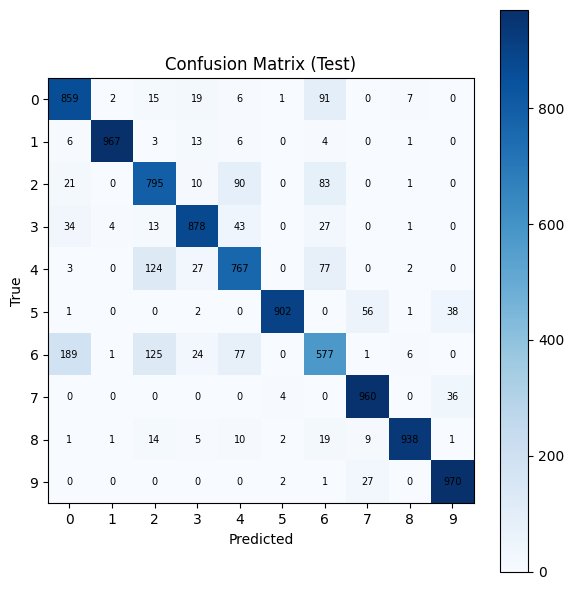


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.77      0.86      0.81      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.73      0.80      0.76      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.77      0.77      0.77      1000
      Sandal       0.99      0.90      0.94      1000
       Shirt       0.66      0.58      0.61      1000
     Sneaker       0.91      0.96      0.94      1000
         Bag       0.98      0.94      0.96      1000
  Ankle boot       0.93      0.97      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
# Final Model — Train on (Train+Val) & Evaluate on Test
x_trval_scaled = np.vstack([x_train_scaled, x_val_scaled])
y_trval = np.concatenate([y_train, y_val])

final_clf = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric, n_jobs=-1)

t0f = time.time(); final_clf.fit(x_trval_scaled, y_trval); fit_t = time.time()-t0f
t0p = time.time(); y_test_pred = final_clf.predict(x_test_scaled); pred_t = time.time()-t0p

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
rec  = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
f1   = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Best params: k={best_k}, metric={best_metric}")
print(f"Test Accuracy={acc:.4f}, Macro P={prec:.4f}, R={rec:.4f}, F1={f1:.4f}")
print(f"Training time={fit_t:.3f}s | Prediction time={pred_t:.3f}s")

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=7)
plt.xticks(range(10), range(10)); plt.yticks(range(10), range(10))
plt.colorbar(); plt.tight_layout(); plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=CLASS_NAMES))


Top-3 confused pairs (true→pred): [('6-Shirt', '0-T-shirt/top'), ('6-Shirt', '2-Pullover'), ('4-Coat', '2-Pullover')]


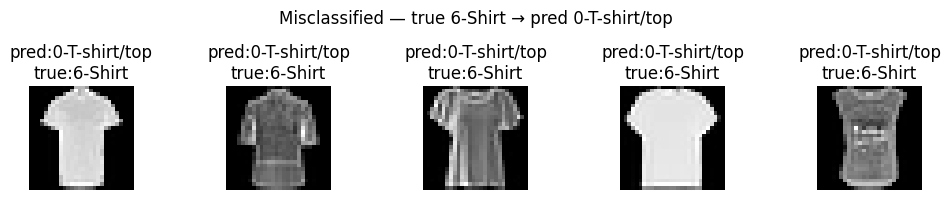

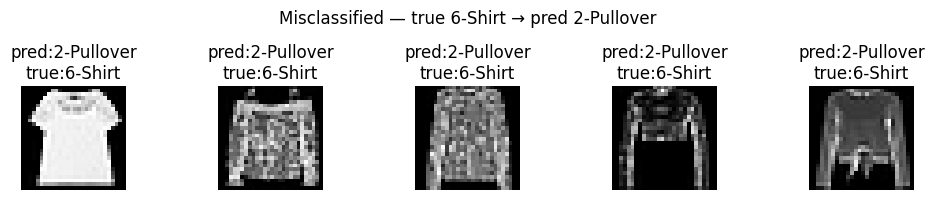

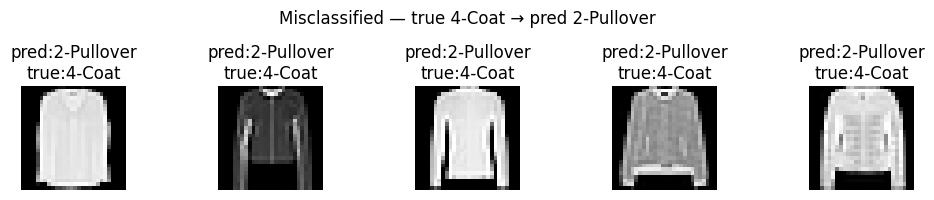

In [ ]:
# Error Analysis
pairs = [((i,j), cm[i,j]) for i in range(10) for j in range(10) if i!=j]
pairs.sort(key=lambda x: x[1], reverse=True)
top3_pairs = [p for p,cnt in pairs[:3] if cnt>0]
print("Top-3 confused pairs (true→pred):", [(f"{a}-{CLASS_NAMES[a]}", f"{b}-{CLASS_NAMES[b]}") for a,b in top3_pairs])

mis_idx = defaultdict(list)
for idx,(t,p) in enumerate(zip(y_test, y_test_pred)):
    if t!=p and (t,p) in top3_pairs:
        mis_idx[(t,p)].append(idx)

for (t,p) in top3_pairs:
    idxs = mis_idx[(t,p)]
    if not idxs: continue
    sample = random.sample(idxs, min(5,len(idxs)))
    plt.figure(figsize=(10,2))
    for i,idx in enumerate(sample,1):
        plt.subplot(1,len(sample),i)
        plt.imshow(x_test[idx], cmap='gray')
        plt.title(f"pred:{p}-{CLASS_NAMES[p]}\ntrue:{t}-{CLASS_NAMES[t]}")
        plt.axis('off')
    plt.suptitle(f"Misclassified — true {t}-{CLASS_NAMES[t]} → pred {p}-{CLASS_NAMES[p]}")
    plt.tight_layout(); plt.show()


In [ ]:
# Timing Summary
print("Validation results:")
for k,metric,acc,ft,pt in val_results:
    print(f"k={k}, metric={metric:<9s}, val_acc={acc:.4f}, fit={ft:.3f}s, pred={pt:.3f}s")
print(f"\nFinal model → fit={fit_t:.3f}s, predict={pred_t:.3f}s")

print("\nWhy k-NN is a lazy learner:")
print("- It performs almost no 'training'; simply stores the data.")
print("- Prediction requires distance computation with all samples, making inference slow.")


Validation results:
k=1, metric=euclidean, val_acc=0.8521, fit=0.023s, pred=2.503s
k=3, metric=euclidean, val_acc=0.8553, fit=0.009s, pred=2.349s
k=5, metric=euclidean, val_acc=0.8548, fit=0.008s, pred=2.288s
k=7, metric=euclidean, val_acc=0.8562, fit=0.008s, pred=2.125s
k=1, metric=manhattan, val_acc=0.8570, fit=0.008s, pred=37.431s
k=3, metric=manhattan, val_acc=0.8631, fit=0.008s, pred=35.380s
k=5, metric=manhattan, val_acc=0.8661, fit=0.009s, pred=35.404s
k=7, metric=manhattan, val_acc=0.8643, fit=0.009s, pred=35.999s

Final model → fit=0.031s, predict=46.206s

Why k-NN is a lazy learner:
- It performs almost no 'training'; simply stores the data.
- Prediction requires distance computation with all samples, making inference slow.


In [ ]:
# Sanity check
print("x_train_scaled:", x_train_scaled.shape, x_train_scaled.dtype)
print("x_val_scaled:  ", x_val_scaled.shape)
print("x_test_scaled: ", x_test_scaled.shape)
print("Sample preds:", final_clf.predict(x_test_scaled[:10]).tolist())
print("True labels :", y_test[:10].tolist())


x_train_scaled: (48000, 784) float32
x_val_scaled:   (12000, 784)
x_test_scaled:  (10000, 784)
Sample preds: [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
True labels : [9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
